# Seedtag - Clasificación de Imágenes

# Setup

Comprobar la GPU que nos ha tocado en Colab (con suerte una V-100 o una P-100).

---



In [ ]:
!nvidia-smi

Thu Mar  4 13:25:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Descargar en el entorno virtual de Colab las librerías necesarias de Github.

---



In [ ]:
!git clone https://github.com/jmsamblas/seedtag_codetest
%cd seedtag_codetest

Cloning into 'seedtag_codetest'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 49 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.
/content/seedtag_codetest


Descargar la base de datos con la que entrenar y evaluar la red.

---



In [ ]:
import pathlib
import tensorflow as tf
import os

if not os.path.exists("/content/seedtag_codetest/datasets"):
  os.mkdir("/content/seedtag_codetest/datasets")
if not os.path.exists("/content/seedtag_codetest/images"):
  os.mkdir("/content/seedtag_codetest/images")

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("/content/seedtag_codetest/datasets/flower_photos.tar.gz", origin=dataset_url, untar=False)

print(f"Dataset saved at: {data_dir}")

!tar -xvf  "/content/seedtag_codetest/datasets/flower_photos.tar.gz" -C "/content/seedtag_codetest/datasets/"

228818944/228813984 [==============================] - 1s 0us/step
Dataset saved at: /content/seedtag_codetest/datasets/flower_photos.tar.gz
flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_

# Atacamos a los Rebeldes con ¡IMÁGENES ADVERSARIAS!

Si lanzamos el código que se encuentra en src/model.py, podemos ver que la imagen del labrador es clasificada con un 50.60% de confidencia.

---




40960/35363 [==================================] - 0s 0us/step
Labrador_retriever : 50.60% Confidence


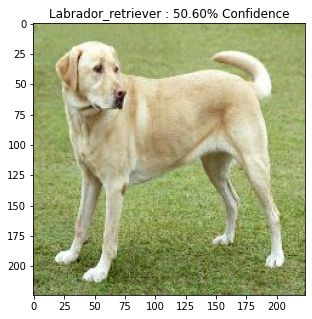

In [ ]:
import os
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False

def load_image(path='assets/test_image.jpg'):
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_image(image_raw)
    return image

def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

def get_imagenet_label(probs):
    return tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=1)[0][0]

# This loads and saves the model
model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
model.trainable = False
model.save('assets/model.h5')

# This loads the image and classify it
image = load_image()
image = preprocess(image)
probs = model.predict(image)

# This plots the results
plt.figure()
plt.imshow(image[0]*0.5+0.5)
_, image_class, class_confidence = get_imagenet_label(probs)
result = '{} : {:.2f}% Confidence'.format(image_class, class_confidence*100)
print(result)
plt.title(result)
plt.show()

Existen muchas maneras de modificar una imagen para confundir a una red neuronal. En concreto, cualquier tipo de transformación afín a la imagen o el añadido de algún tipo de oclusión suele confundirlas, siempre y cuando el modelo no haya sido entrenado previamente para combatir estas situaciones mediante data augmentation (las CNNs no suelen ser invariantes a estas transformaciones por defecto). El principal problema es que todas estas transformaciones modifican la imagen de una forma tan agresiva que cualquier Rebelde se daría cuenta de que ha sido alterada.

No obstante, existe un tipo de modificación que podemos realizar a la imagen de modo que engañe a la red y sea prácticamente indistinguible para nosotros. Es el caso de los ataques adversarios, basados en el siguiente principio; Al igual que podemos actualizar los pesos de una red a medida que la entrenamos para minimizar la loss, también podemos revertir este proceso y modificar la imagen para **maximizarla**. En particular, uno de los ataques más simples y, el que usaremos en este notebook, es el llamado [FGSM](https://arxiv.org/abs/1412.6572) o *Fast Gradient Signed Method*. La fórmula con la que se alteran las imágenes mediante este método sigue la siguiente expresión:

$$x\_adv = x + \epsilon*\text{sign}(\nabla_x J(\theta, x, y))$$

Donde epsilon es el factor de escalado con el que queremos aplicar la transformación y del que dependerá que los Rebeldes nos detecten o no. Nótese cómo esta fórmula recuerda a la del descenso del gradiente, que es prácticamente igual pero actualizando los pesos en vez de la imagen (y por tanto calculando la derivada con respecto a los pesos):

$$\theta\_new = \theta\_old - LR*\nabla_\theta J(\theta, x, y)$$

*   $LR$: learning rate
*   $x$: imagen
*   $y$: etiqueta de la imagen
*   $\theta$ : pesos
*   $J$ : loss

Utilizando Tensorflow, FGSM puede implementarse tal y como se muestra en el siguiente bloque de código (código sacado de este [notebook](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/adversarial_fgsm.ipynb)). Nota: FGSM asume que tenemos información y acceso al modelo antes de enviar la imagen. En caso de que no lo tuviéramos, tendríamos que utilizar métodos algo más elaborados como los que aparecen en esta [survey](https://arxiv.org/abs/1906.06032).



---





In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern(model, input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

A continuación modificamos la imagen para distintos valores de epsilon. Podemos ver que a medida que epsilon aumenta, las prestaciones del modelo disminuyen.

---



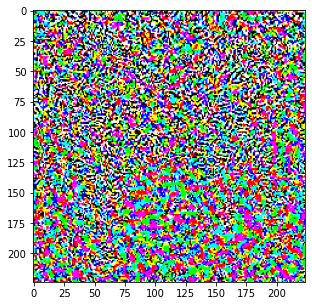

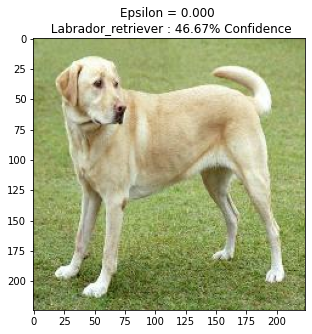

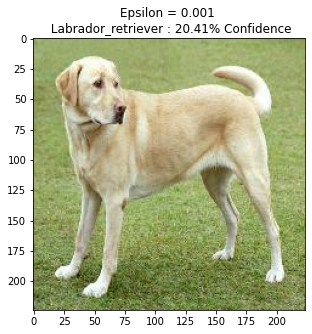

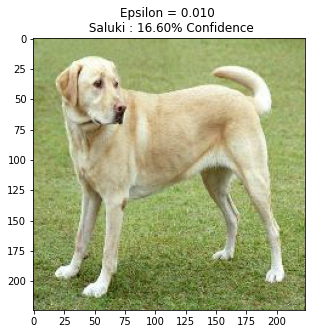

In [ ]:
def display_images(model, image, description):
  _, label, confidence = get_imagenet_label(model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

# Get the input label of the image
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, probs.shape[-1])
label = tf.reshape(label, (1, probs.shape[-1]))

perturbations = create_adversarial_pattern(model, image, label)
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

epsilons = [0.0001, 0.001, 0.01]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]
adv_x_list = []

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  adv_x_list.append(adv_x)
  display_images(model, adv_x, descriptions[i])

######## IGNORAR ESTE BLOQUE ########

El siguiente bloque de código calcula la diferencia a nivel de píxel en formato RGB entre imágenes normales y adversarias para los valores de epsilon calculados anteriormente. Podemos ver que valores de eps menores o iguales a 0.001 obtienen un 98% de píxeles prácticamente iguales a la imagen original. De este modo, parece que eps = 0.001 es un buen límite intermedio, ya que proporciona prestaciones realmente bajas (20% de confidencia) a la vez que hace que las imágenes adversarias sean prácticamente indistinguibles.

Por tanto, de aquí en adelante utilizaremos este valor siempre que tengamos que utilizar un ataque adversario en este notebook (cuando entrenemos la red nosotros).

---



In [ ]:
import numpy as np

for counter_adv_x, adv_x in enumerate(adv_x_list):

    print("eps: {}".format(epsilons[counter_adv_x]))

    image_back_to_normal = (image + 1) * 255 / 2
    image_back_to_normal = image_back_to_normal.numpy().astype('uint8')
    image_back_to_normal = image_back_to_normal[0]

    image_adv_back_to_normal = (adv_x + 1) * 255 / 2
    image_adv_back_to_normal = image_adv_back_to_normal.numpy().astype('uint8')
    image_adv_back_to_normal = image_adv_back_to_normal[0]

    print('imagen normal, píxel 0,0, RGB:', image_back_to_normal[0,0,:])
    print('imagen adversaria, píxel 0,0, RGB:', image_adv_back_to_normal[0,0,:])
    print('imagen normal, píxel 0,1, RGB:', image_back_to_normal[0,1,:])
    print('imagen adversaria, píxel 0,1, RGB:', image_adv_back_to_normal[0,1,:])

    difference_img = image_back_to_normal - image_adv_back_to_normal
    # difference_img = np.abs(image_back_to_normal.astype(np.int16) - image_adv_back_to_normal.astype(np.int16))
    print("porcentaje de píxeles cuya diferencia es mayor a 1: {}%".format(round(100*np.count_nonzero(difference_img > 1)/np.count_nonzero(difference_img >= 0)),2))
    print("porcentaje de píxeles cuya diferencia es menor a 1: {}%".format(round(100*np.count_nonzero(difference_img <= 1)/np.count_nonzero(difference_img >= 0)),2))

    if counter_adv_x < len(adv_x_list) - 1:
        print("\n")


eps: 0.0001
imagen normal, píxel 0,0, RGB: [140 159  93]
imagen adversaria, píxel 0,0, RGB: [140 158  93]
imagen normal, píxel 0,1, RGB: [149 168 102]
imagen adversaria, píxel 0,1, RGB: [149 168 102]
porcentaje de píxeles cuya diferencia es mayor a 1: 2%
porcentaje de píxeles cuya diferencia es menor a 1: 98%


eps: 0.001
imagen normal, píxel 0,0, RGB: [140 159  93]
imagen adversaria, píxel 0,0, RGB: [140 158  93]
imagen normal, píxel 0,1, RGB: [149 168 102]
imagen adversaria, píxel 0,1, RGB: [149 168 102]
porcentaje de píxeles cuya diferencia es mayor a 1: 2%
porcentaje de píxeles cuya diferencia es menor a 1: 98%


eps: 0.01
imagen normal, píxel 0,0, RGB: [140 159  93]
imagen adversaria, píxel 0,0, RGB: [141 157  94]
imagen normal, píxel 0,1, RGB: [149 168 102]
imagen adversaria, píxel 0,1, RGB: [150 169 103]
porcentaje de píxeles cuya diferencia es mayor a 1: 98%
porcentaje de píxeles cuya diferencia es menor a 1: 2%


**Más información acerca de epsilon:**

En realidad, este factor de escalado epsilon, es la diferencia numérica de píxeles entre ambas imágenes, en formato float32 (y en el rango de -1 a 1). Si lo que queremos es que la diferencia en formato int RGB sea como máximo 1, tenemos que convertir epsilon de (-1,1) a (0,255) y obtener el límite máximo.

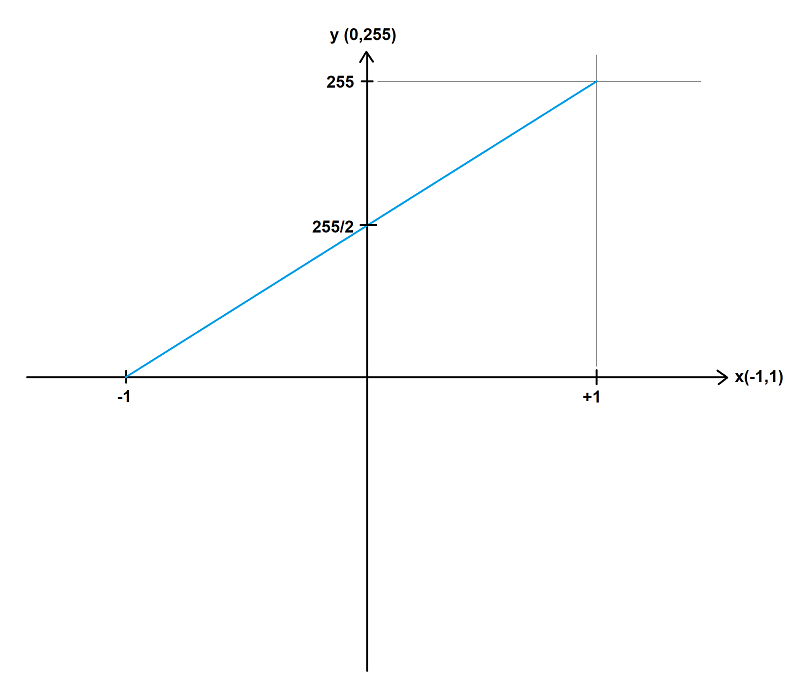

La ecuación que sigue la transformaciones entre dominios es la siguiente ("y" es el dominio de 0 a 255 y "x" el de -1 a 1):

$$y = \alpha(x + 1)$$

Donde $\alpha$ equivale a 255/2. Si lo que queremos es que el valor absoluto entre y sea menor que 1:

$$||y_1 - y_2|| = ||\alpha(x_1 + 1) - \alpha(x_2+1)||$$

$$||y_1 - y_2|| = \alpha||x_1-x_2|| \leq 1$$

$$||x_1-x_2|| \leq \frac1\alpha$$

Llegamos a la conclusión de que el epsilon óptimo es 0.008 (épsilon que nos permite engañar más a la red y que cumpla la condición de que la distancia máxima sea 1):

$$\epsilon = ||x_1-x_2|| \leq \frac{2}{255} \approx 0.008$$

Aunque 0.001 también nos vale.

---



# Entrenamiento normal (sin tener en cuenta los posibles ataques enemigos)

A partir de este momento vamos a utilizar PyTorch en vez de Tensorflow para ahorrar algo de tiempo reciclando código de proyectos antiguos. En principio en Google Colab no hay que instalar nada ya que la última versión de PyTorch viene preinstalada por defecto.

La red neuronal que vamos a utilizar es [ResNet-50](https://arxiv.org/abs/1512.03385). Probablemente utilizar una red con más parámetros (como ResNet-152) o alguna más moderna (del tipo [EfficientNet](https://arxiv.org/abs/1905.11946)) nos ofrecería mejores resultados. Pero la diferencia tampoco sería abismal y por motivos prácticos, ResNet-50 ofrece el mejor tradeoff.

Para no saturar el notebook de código, he recogido en la carpeta utils el grueso de las funciones que vamos a utilizar. En concreto para los ataques adversarios con FGSM vamos a utilizar la biblioteca [cleverhans](https://github.com/cleverhans-lab/cleverhans) que ya está optimizada para PyTorch (no hay que bajarse nada ya que la función está en la propia carpeta).

---



Imports necesarios para entrenar / analizar la red.

---



In [ ]:
from collections import namedtuple
from utils.resnet import *
from utils.utils import *
import torch
import copy
import os
import random
import shutil
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import precision_recall_fscore_support

Inicializamos una seed para que los resultados sean reproducibles.

---



In [ ]:
# RANDOM SEEDS FOR REPRODUCIBILITY

def seed_worker(worker_id):

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def seed_all(seed):

    if not seed:
        seed = 10

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(9999)

[ Using Seed :  9999  ]


Hacemos un split de 80% train / 20% test y creamos un par de carpetas train y test para que el DataLoader de PyTorch funcione correctamente. Del 80% de train sacaremos un 10% para validar posteriormente.

---



In [ ]:
# SPLIT TRAIN AND TEST (CREATING DIRS)

ROOT = 'datasets'
SPLIT_TRAIN_AND_TEST = 'True'
TRAIN_RATIO = 0.8

images_dir = os.path.join(ROOT, 'flower_photos')
train_dir = os.path.join(ROOT, 'train')
test_dir = os.path.join(ROOT, 'test')

if SPLIT_TRAIN_AND_TEST:

    if os.path.exists(train_dir):
        shutil.rmtree(train_dir) 
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)
        
    os.makedirs(train_dir)
    os.makedirs(test_dir)
    
    classes = os.listdir(images_dir)
    
    for c in tqdm(classes):
        
        class_dir = os.path.join(images_dir, c)
        
        if os.path.isdir(class_dir):
            images = os.listdir(class_dir)
        else:
            continue
           
        n_train = int(len(images) * TRAIN_RATIO)
        
        train_images = images[:n_train]
        test_images = images[n_train:]
        
        os.makedirs(os.path.join(train_dir, c), exist_ok = True)
        os.makedirs(os.path.join(test_dir, c), exist_ok = True)
        
        for image in train_images:
            image_src = os.path.join(class_dir, image)
            image_dst = os.path.join(train_dir, c, image) 
            shutil.copyfile(image_src, image_dst)
            
        for image in test_images:
            image_src = os.path.join(class_dir, image)
            image_dst = os.path.join(test_dir, c, image) 
            shutil.copyfile(image_src, image_dst)

100%|██████████| 6/6 [00:00<00:00,  9.44it/s]


Puesto que vamos a hacer transfer learning de ResNet-50 pre-entrenado en ImageNet, hay que preprocesar un poco las imágenes de entrada, de forma que tengan el mismo tamaño (224x224) y usen la misma normalización.

Además vamos a usar algo de data augmentation, que nunca viene mal en un problema de clasificación de imágenes:


1.   Rotaciones
2.   Flips horizontales
3.   Crops aleatorios

Obviamente, habría que hacer algunas pruebas para obtener la mejor configuración del augmentation pipeline (o quizás usar también otros augments como cambios en la intensidad de píxel o alguna inclusión de ruido espacial), pero por simplicidad vamos a mantener augments bastante sencillos y seguros (como rotaciones de +/- 5 grados como máximo).

Para no hacer augmentation, simplemente poner AUGMENTATION a False.

---







In [ ]:
# SET TRAIN AND TEST TRANSFORMS (PREPROCESSING AND AUGMENTATIONS)

AUGMENTATION = True

pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406] # image-net
pretrained_stds = [0.229, 0.224, 0.225] # image-net

# WITH AUGMENTS

if AUGMENTATION:

    train_transforms = transforms.Compose([
                               transforms.Resize(pretrained_size),
                               transforms.RandomRotation(5),
                               transforms.RandomHorizontalFlip(0.5),
                               transforms.RandomCrop(pretrained_size, padding = 10),
                               transforms.ToTensor(),
                               transforms.Normalize(mean = pretrained_means, 
                                                    std = pretrained_stds)
                           ])
    
    test_transforms = transforms.Compose([
                               transforms.Resize(pretrained_size),
                               transforms.CenterCrop(pretrained_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean = pretrained_means, 
                                                    std = pretrained_stds)
                           ])

# WITHOUT AUGMENTS

else:
    
    train_transforms = transforms.Compose([
                               transforms.Resize((pretrained_size, pretrained_size)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean = pretrained_means, 
                                                    std = pretrained_stds)
                           ])
    
    test_transforms = transforms.Compose([
                               transforms.Resize(pretrained_size),
                               transforms.CenterCrop(pretrained_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean = pretrained_means, 
                                                    std = pretrained_stds)
                           ])

Creamos los DataLoaders, el set de validación y el batch size. Por defecto el BATCH_SIZE es igual a 16 para estar seguros en Colab y que no se nos caiga el código por un CUDA OUT OF MEMORY. En caso de que el error ocurra igualmente, bajarlo aún más, pese a que la convergencia del modelo sea peor.

---



In [ ]:
# SET TRAIN AND TEST DATALOADERS (AND VAL)

VALID_RATIO = 0.1
BATCH_SIZE = 16

train_data = datasets.ImageFolder(root = train_dir, transform = train_transforms)
test_data = datasets.ImageFolder(root = test_dir, transform = test_transforms)

n_train_examples = int(len(train_data) * (1-VALID_RATIO))
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

train_iterator = data.DataLoader(train_data, shuffle = True, batch_size = BATCH_SIZE, worker_init_fn=seed_worker)
valid_iterator = data.DataLoader(valid_data, batch_size = BATCH_SIZE, worker_init_fn=seed_worker)
test_iterator = data.DataLoader(test_data, batch_size = 1, worker_init_fn=seed_worker)

Number of training examples: 2640
Number of validation examples: 294
Number of testing examples: 736


A continuación se muestran algunos samples de entrenamiento con los augments ya realizados para comprobar que todo está en orden.

---



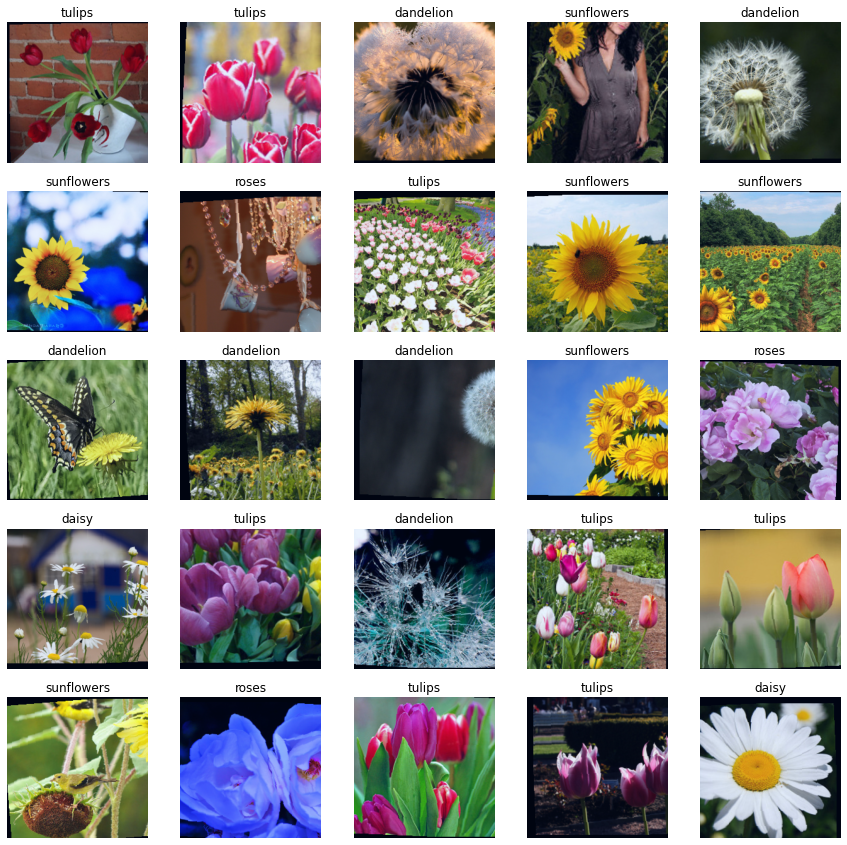

In [ ]:
images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(30)]])
classes = test_data.classes
plot_images(images, labels, classes)

Descargamos y cargamos ResNet-50 pre-entrenado en ImageNet. La última capa fully connected la cambiamos por una nueva que se adapte a nuestras 5 clases de flores (y no a 1000 como ocurre en ImageNet).

---



In [ ]:
# LOAD AND IMPORT MODEL

pretrained_model = models.resnet50(pretrained = True)
# print(pretrained_model)

IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet50_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 4, 6, 3], channels = [64, 128, 256, 512])

model = ResNet(resnet50_config, OUTPUT_DIM)
model.load_state_dict(pretrained_model.state_dict())

print(f'The model has {count_parameters(model):,} trainable parameters')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



The model has 23,518,277 trainable parameters


Configuramos el learning rate que vamos a emplear. Como primera aproximación, hacemos un barrido progresivo con diferentes LRs, utilizando el método de este [paper](https://arxiv.org/abs/1506.01186), quedándonos con el que nos otorgue la loss más baja, que como podemos ver en el plot, está entre 1e-2 y 1e-3.

Puesto que estamos haciendo transfer learning y nuestro dataset no es enorme, vamos a utilizar LRs menores para las primeras capas de la red (estas capas son las que aprenden características más genéricas y propias de cualquier dataset como bordes y blobs y, por tanto, no requieren de un entrenamiento muy agresivo). Otra opción habría sido congelarlas y que directamente no entrenaran. 

---



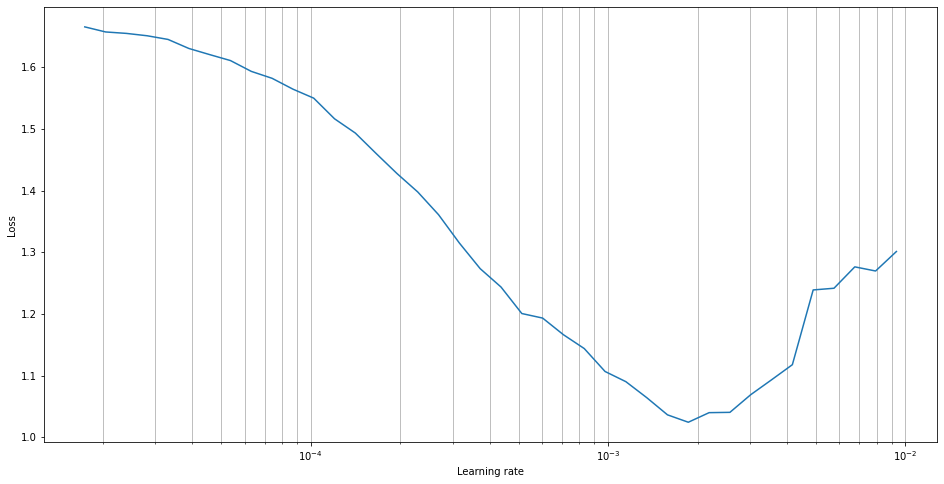

In [ ]:
# LR SETUP

optimizer = optim.Adam(model.parameters(), lr=1e-7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, 1, 100)
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

FOUND_LR = lrs[losses.index(min(losses))]

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
          ]

optimizer = optim.Adam(params, lr = FOUND_LR)

Configuramos un scheduler para que el LR decaiga a medida que entrenamos (en concreto con el OneCycleLR primero aumenta un poco y luego decae en las últimas epochs).

---



In [ ]:
# SET SCHEDULER

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
MAX_LRS = [p['lr'] for p in optimizer.param_groups]
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr = MAX_LRS, total_steps = TOTAL_STEPS)

Entrenamos durante 10 epochs. Uilizamos la accuracy para monitorizar el set de validación, con el fin de quedarnos con la epoch que mejor accuracy de validación obtenga (técnica conocida como early stopping).

---



In [ ]:
# START TRAINING

best_valid_loss = float('inf')

train_loss_list = []
valid_loss_list = []
train_acc_1_list = []
valid_acc_1_list = []

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, _ = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, _ = evaluate(model, valid_iterator, criterion, device)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_acc_1_list.append(train_acc_1)
    valid_acc_1_list.append(valid_acc_1)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'resnet50_without_adversarial_training.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc_1*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc_1*100:6.2f}%')

Epoch: 00 | Epoch Time: 0m 35s
	Train Loss: 0.566 | Train Acc:  81.06%
	Valid Loss: 0.325 | Valid Acc:  89.14%
Epoch: 01 | Epoch Time: 0m 35s
	Train Loss: 0.535 | Train Acc:  82.58%
	Valid Loss: 1.584 | Valid Acc:  67.00%
Epoch: 02 | Epoch Time: 0m 35s
	Train Loss: 0.618 | Train Acc:  79.55%
	Valid Loss: 0.338 | Valid Acc:  90.24%
Epoch: 03 | Epoch Time: 0m 35s
	Train Loss: 0.416 | Train Acc:  85.53%
	Valid Loss: 0.412 | Valid Acc:  85.64%
Epoch: 04 | Epoch Time: 0m 35s
	Train Loss: 0.341 | Train Acc:  88.45%
	Valid Loss: 0.239 | Valid Acc:  91.78%
Epoch: 05 | Epoch Time: 0m 35s
	Train Loss: 0.235 | Train Acc:  92.69%
	Valid Loss: 0.278 | Valid Acc:  90.13%
Epoch: 06 | Epoch Time: 0m 35s
	Train Loss: 0.166 | Train Acc:  94.24%
	Valid Loss: 0.188 | Valid Acc:  94.08%
Epoch: 07 | Epoch Time: 0m 35s
	Train Loss: 0.100 | Train Acc:  96.67%
	Valid Loss: 0.184 | Valid Acc:  93.75%
Epoch: 08 | Epoch Time: 0m 35s
	Train Loss: 0.068 | Train Acc:  97.61%
	Valid Loss: 0.169 | Valid Acc:  93.75%
E

Hacemos un plot de las accuracies en función del número de epochs para comprobar que nuestro modelo ha convergido. Podemos ver que en la epoch 9 se alcanza el mejor modelo de validación (que es el que vamos a emplear en test).

Además podemos observar cómo la accuracy de training empieza a aplanarse a partir de la epoch 8/9. Quizás entrenando unas cuantas epochs más obtendríamos mejores prestaciones (aunque tampoco muchas más que no queremos overfitting), pero por tiempo vamos a usar sólo 10.

---



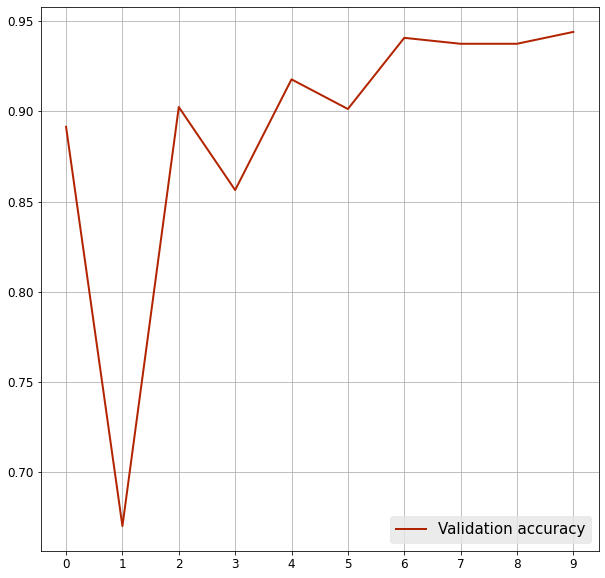

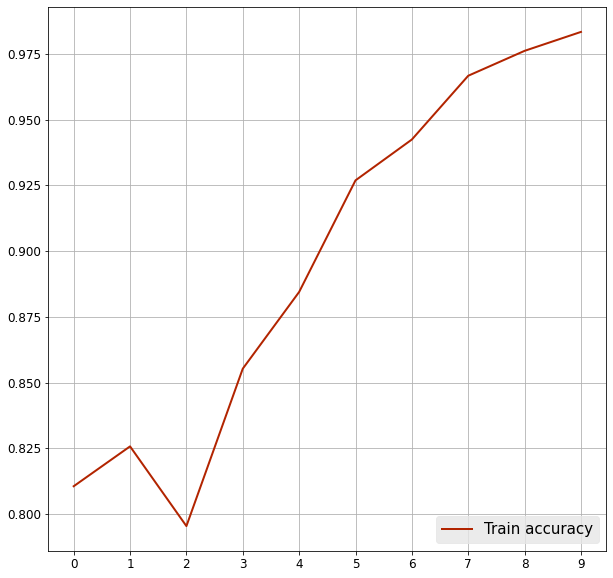

In [ ]:
# PRINT LOSS AND ACC OVER EPOCHS

params = {
   'legend.fontsize': 15,
   'axes.labelsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [10, 10]
   }
plt.rcParams.update(params)
plt.plot(range(EPOCHS), valid_acc_1_list, linewidth=2, color='#B22400')
legend = plt.legend(["Validation accuracy"], loc=4);
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.9')
plt.xticks(list(range(EPOCHS)))
plt.grid()
plt.savefig('images/plot_val_acc.png', dpi=300)
plt.show()

params = {
   'legend.fontsize': 15,
   'axes.labelsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [10, 10]
   }
plt.rcParams.update(params)
plt.plot(range(EPOCHS), train_acc_1_list  , linewidth=2, color='#B22400')
legend = plt.legend(["Train accuracy"], loc=4);
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.9')
plt.xticks(list(range(EPOCHS)))
plt.grid()
plt.savefig('images/plot_train_acc.png', dpi=300)
plt.show()

Evaluamos en test, obteniendo una accuracy del 94.02%. Al final del notebook veremos los casos en los que la red falla para intentar comprender un poco mejor nuestro modelo.

In [ ]:
# LOAD BEST MODEL

torch.cuda.empty_cache()

model.load_state_dict(torch.load('resnet50_without_adversarial_training.pt'))
test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc_1*100:6.2f}%')

Test Loss: 0.166 | Test Acc:  94.02%


Volvemos a evaluar. Esta vez sometemos las imágenes de test a un ataque adversario mediante FGSM. Para ello simplemente incluimos en la evaluación la siguiente línea de código (utilizando cleverhans):


```
x = fast_gradient_method(model, x, eps=epsilon, norm=np.inf, clip_min=0., clip_max=1.)
```

Como podemos comprobar, la accuracy ha bajado considerablemente (el doble), por lo que debemos replantearnos una estrategia que nos consiga algo más de robustez.

---



In [ ]:
# TRY BEST MODEL WITH ADVERSARIAL EXAMPLES

torch.cuda.empty_cache()

model.load_state_dict(torch.load('resnet50_without_adversarial_training.pt'))
test_loss, test_acc_1, test_acc_5 = evaluate_under_attack(model, test_iterator, criterion, device, epsilon = 0.1)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc_1*100:6.2f}%')

Test Loss: 2.445 | Test Acc:  44.97%


# Entrenamiento adversario

La estrategia que vamos a utilizar para intentar ganar algo de robustez frente a imágenes adversarias es bastante simple y podría considerarse como data augmentation. Simplemente, en cada batch de entrenamiento vamos a volver a entrenar pasándole como input a la red las imágenes alteradas de forma adicional, con la intención de que la red no sólo aprenda a distinguir las imágenes normales sino también las modificadas (el código está en utils/utils.adversarial_training). Esta estrategia se puede aplicar a cualquier tipo de ataque. Nota: el tiempo de entrenamiento es mayor en este caso ya que entrenamos con el doble de imágenes (y además tenemos que calcular los ejemplos adversarios en cada batch).

---



In [ ]:
# SET TRAIN AND TEST DATALOADERS (AND VAL)

VALID_RATIO = 0.1
BATCH_SIZE = 16

train_data = datasets.ImageFolder(root = train_dir, transform = train_transforms)
test_data = datasets.ImageFolder(root = test_dir, transform = test_transforms)

n_train_examples = int(len(train_data) * (1-VALID_RATIO))
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

train_iterator = data.DataLoader(train_data, shuffle = True, batch_size = BATCH_SIZE, worker_init_fn=seed_worker)
valid_iterator = data.DataLoader(valid_data, batch_size = BATCH_SIZE, worker_init_fn=seed_worker)
test_iterator = data.DataLoader(test_data, batch_size = 1, worker_init_fn=seed_worker)

# LOAD AND IMPORT MODEL

pretrained_model = models.resnet50(pretrained = True)
# print(pretrained_model)

IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet50_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 4, 6, 3], channels = [64, 128, 256, 512])

model = ResNet(resnet50_config, OUTPUT_DIM)
model.load_state_dict(pretrained_model.state_dict())

print(f'The model has {count_parameters(model):,} trainable parameters')

# LR SETUP

optimizer = optim.Adam(model.parameters(), lr=1e-7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

FOUND_LR = lrs[losses.index(min(losses))]

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
          ]

optimizer = optim.Adam(params, lr = FOUND_LR)

# SET SCHEDULER

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
MAX_LRS = [p['lr'] for p in optimizer.param_groups]
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr = MAX_LRS, total_steps = TOTAL_STEPS)

# START TRAINING

best_valid_loss = float('inf')

train_loss_list = []
valid_loss_list = []
train_acc_1_list = []
valid_acc_1_list = []

torch.cuda.empty_cache()

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = adversarial_training(model, train_iterator, optimizer, criterion, scheduler, device, epsilon=0.1)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_acc_1_list.append(train_acc_1)
    valid_acc_1_list.append(valid_acc_1)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'resnet50_with_adversarial_training.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc_1*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc_1*100:6.2f}%')

Number of training examples: 2640
Number of validation examples: 294
Number of testing examples: 736
The model has 23,518,277 trainable parameters
Epoch: 00 | Epoch Time: 1m 18s
	Train Loss: 0.669 | Train Acc:  74.75%
	Valid Loss: 0.349 | Valid Acc:  90.24%
Epoch: 01 | Epoch Time: 1m 18s
	Train Loss: 0.702 | Train Acc:  74.49%
	Valid Loss: 0.404 | Valid Acc:  86.51%
Epoch: 02 | Epoch Time: 1m 18s
	Train Loss: 0.646 | Train Acc:  75.98%
	Valid Loss: 0.391 | Valid Acc:  85.64%
Epoch: 03 | Epoch Time: 1m 18s
	Train Loss: 0.567 | Train Acc:  77.58%
	Valid Loss: 0.306 | Valid Acc:  90.90%
Epoch: 04 | Epoch Time: 1m 17s
	Train Loss: 0.488 | Train Acc:  81.29%
	Valid Loss: 0.298 | Valid Acc:  89.47%
Epoch: 05 | Epoch Time: 1m 17s
	Train Loss: 0.383 | Train Acc:  85.80%
	Valid Loss: 0.268 | Valid Acc:  92.76%
Epoch: 06 | Epoch Time: 1m 17s
	Train Loss: 0.321 | Train Acc:  87.46%
	Valid Loss: 0.207 | Valid Acc:  93.09%
Epoch: 07 | Epoch Time: 1m 17s
	Train Loss: 0.240 | Train Acc:  91.16%
	Vali

De nuevo, comprobamos las gráficas para hacernos una idea de cómo ha ido el entrenamiento (similar al de antes).

---



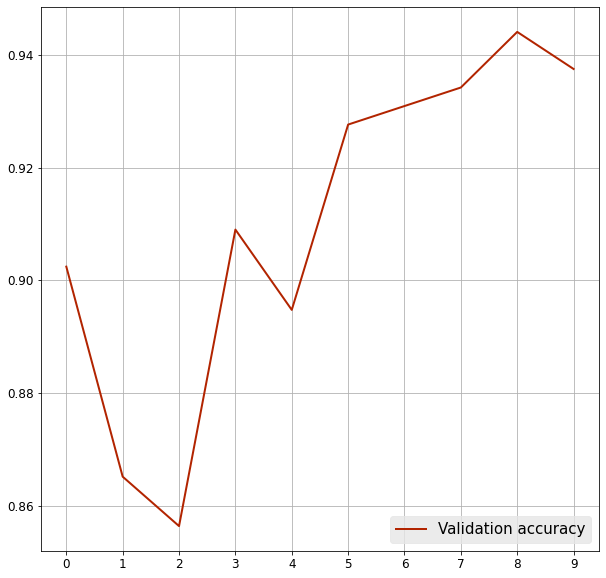

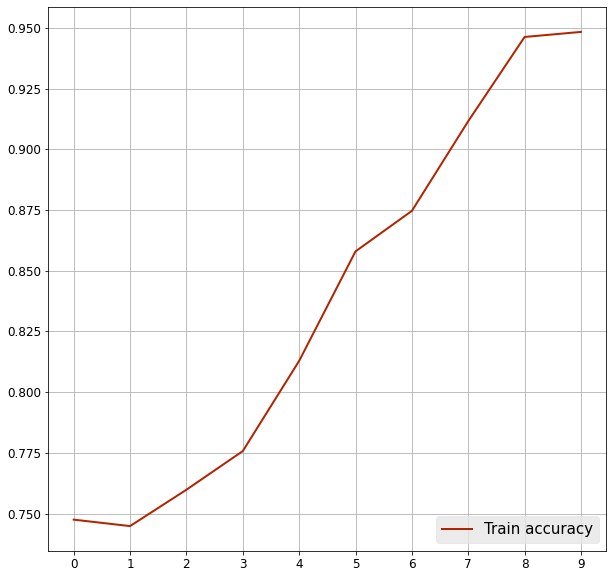

In [ ]:
# PRINT LOSS AND ACC OVER EPOCHS

params = {
   'legend.fontsize': 15,
   'axes.labelsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [10, 10]
   }
plt.rcParams.update(params)
plt.plot(range(EPOCHS), valid_acc_1_list, linewidth=2, color='#B22400')
legend = plt.legend(["Validation accuracy"], loc=4);
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.9')
plt.xticks(list(range(EPOCHS)))
plt.grid()
plt.savefig('images/plot_val_acc.png', dpi=300)
plt.show()

params = {
   'legend.fontsize': 15,
   'axes.labelsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [10, 10]
   }
plt.rcParams.update(params)
plt.plot(range(EPOCHS), train_acc_1_list  , linewidth=2, color='#B22400')
legend = plt.legend(["Train accuracy"], loc=4);
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.9')
plt.xticks(list(range(EPOCHS)))
plt.grid()
plt.savefig('images/plot_train_acc.png', dpi=300)
plt.show()

Evaluamos el modelo, esta vez habiendo entrenado con las imágenes adversarias adicionales. Podemos comprobar que, en este caso, al evaluar con imágenes alteradas, la accuracy ha mejorado notablemente (casi un 30% de mejora).

¡Lo tendrán mucho más complicado los Rebeldes a partir de ahora!

---



In [ ]:
# TRY BEST MODEL WITH ADVERSARIAL EXAMPLES

torch.cuda.empty_cache()

model.load_state_dict(torch.load('resnet50_with_adversarial_training.pt'))
test_loss, test_acc_1, test_acc_5 = evaluate_under_attack(model, test_iterator, criterion, device, epsilon = 0.1)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc_1*100:6.2f}%')

Test Loss: 0.761 | Test Acc:  71.47%


Cabe destacar que, si evaluamos para imágenes normales, el rendimiento ha bajado un poco. Esto es normal debido al ruido que introducen en el entrenamiento las imágenes adversarias, tal y como se explica en este [paper](https://arxiv.org/abs/1906.06032).

---



In [ ]:
# LOAD BEST MODEL

torch.cuda.empty_cache()

model.load_state_dict(torch.load('resnet50_with_adversarial_training.pt'))
test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc_1*100:6.2f}%')

Test Loss: 0.195 | Test Acc:  92.53%


# Análisis adicional

Vamos a analizar un poco las prestaciones y errores del modelo que hemos obtenido (el último: 'resnet50_with_adversarial_training.pt'). Si nos pintamos la matriz de confusión, podemos ver que nuestra red tiene algo de tendencia a confundir las rosas con los tulipanes. Podemos ver que, en 14 ocasiones en las que la imagen de entrada era un tulipán, la red se pensó que se trataba de una rosa. El caso contrario ocurrió 16 veces. Los demás errores no parecen muy significativos.

---



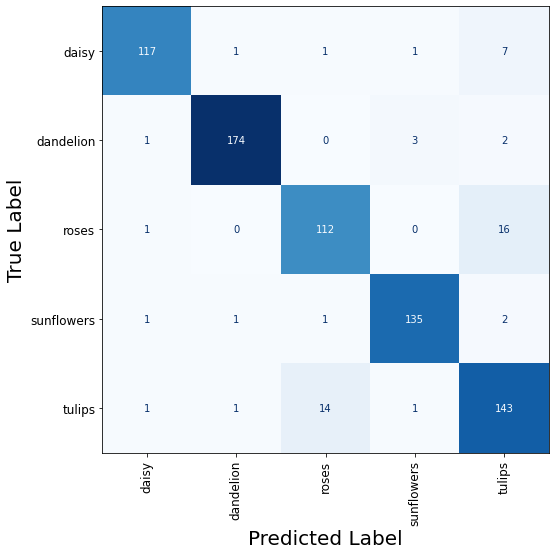

In [ ]:
# CONFUSION MATRIX

images, labels, probs = get_predictions(model, test_iterator, device = device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels, classes)

Mismas conclusiones podemos obtener si sacamos la precisión, recall y f-score de cada una de las clases. Tulipanes y rosas son las que peor rendimiento ofrecen.

---



In [ ]:
# PRECISION, RECALL, FSCORE AND SUPPORT

report = precision_recall_fscore_support(labels.numpy(), pred_labels.numpy())
type_of_metric = ['precision', 'recall', 'fscore', 'support']

for metric_counter, metric in enumerate(report):
    if type_of_metric[metric_counter] == 'support':
        continue
    print("\n{}.".format(metric_counter))
    for cl_counter, cl in enumerate(metric):
        print('{}\'s {}: {}%'.format(test_data.classes[cl_counter], type_of_metric[metric_counter], round(cl*100,2)))


0.
daisy's precision: 96.69%
dandelion's precision: 98.31%
roses's precision: 87.5%
sunflowers's precision: 96.43%
tulips's precision: 84.12%

1.
daisy's recall: 92.13%
dandelion's recall: 96.67%
roses's recall: 86.82%
sunflowers's recall: 96.43%
tulips's recall: 89.38%

2.
daisy's fscore: 94.35%
dandelion's fscore: 97.48%
roses's fscore: 87.16%
sunflowers's fscore: 96.43%
tulips's fscore: 86.67%


A continuación mostramos por pantalla aquellos casos en los que el modelo más se ha confundido. Podemos observar que hay muchos casos en los que simplemente la imagen de entrada estaba mal etiquetada o tenía etiquetas ambiguas. Algunos ejemplos son:

1.   Ramo de flores con margaritas y rosas en la misma foto (la red predice rosas pero la etiqueta es margaritas).
2.   Fotos que directamente no tienen flores (e.g. hay una foto que tiene fresas en vez de flores, también hay varias fotos de coches).

Estos errores son intrínsecos a la propia base de datos y poco se puede hacer al respecto (salvo obviamente re-anotar correctamente los datos).

Sin embargo, sí que podemos observar algunas cosas interesantes con respecto a la confusión tulipanes-rosas:



1.   Muchas de las fotos en las que la red confunde tulipanes con rosas son fotos de tulipanes abiertos y tomadas desde una perspectiva cenital (la típica foto de la flor abierta con los pistilos). El caso contrario existe también; Cuándo la foto es una rosa cerrada, la red cree que se trata de un tulipán. Básicamente la confusión es: flor cerrada = tulipán y flor abierta = rosa.
2.   Otros tantos errores consisten en fotos de tulipanes con colores muy llamativos y generalmente muy parecidos a los de las rosas (flores rojas y moradas).

El segundo de los casos podría resolverse con transformaciones de color a nivel de intensidad de píxel en el augmentation pipeline. Para el primero de los casos, una buena opción sería retocar / balancear directamente la base de datos, de modo que hubiera la misma variedad de rosas y tulipanes con los pétalos abiertos. Aunque esto puede ser algo laborioso ya que los tulipanes son más propensos a tener los pétalos cerrados (sólo los abren unos 20 días al año).

---





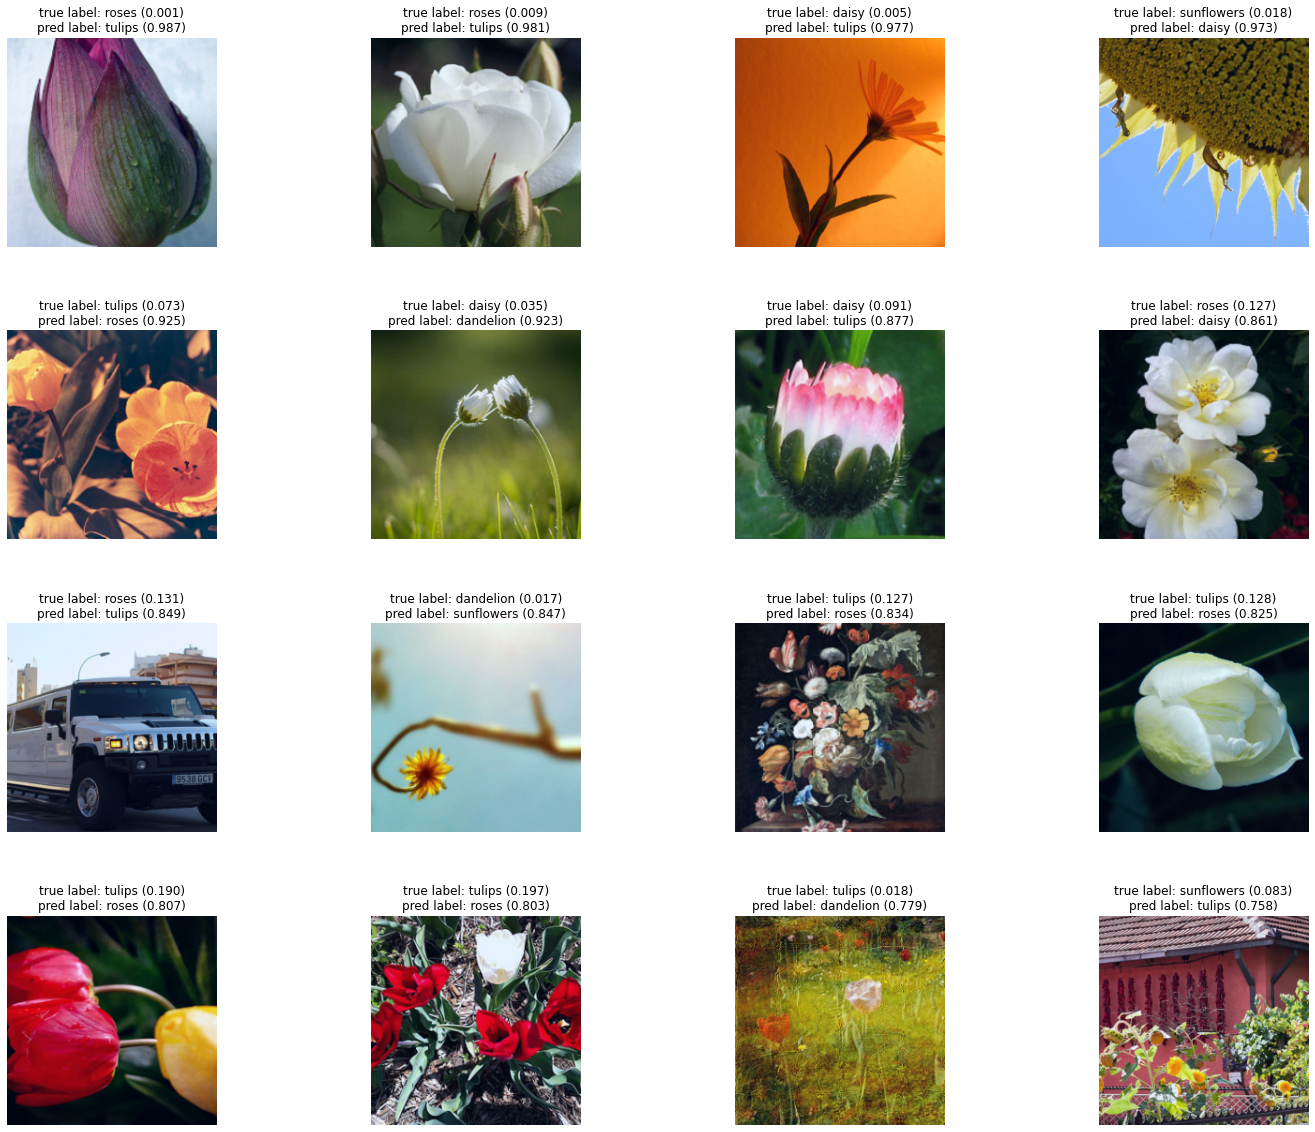

In [ ]:
# INCORRECT SAMPLES

corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

plot_most_incorrect(incorrect_examples, classes, 16)

Para comprender aún más nuestro modelo, una técnica recurrente es reducir la dimensionalidad (a 2 o 3 dimensiones) de los vectores de salida de nuestras imágenes. Para ello vamos a utilizar t-SNE (PCA podría valer también pero t-SNE tiende a dar mejores representaciones ya que es no lineal).

Spoiler: de nuevo hay algo de overlapping entre rosas y tulipanes. Sin embargo, los clusters parecen bastante definidos y diferenciados (buena señal).

---



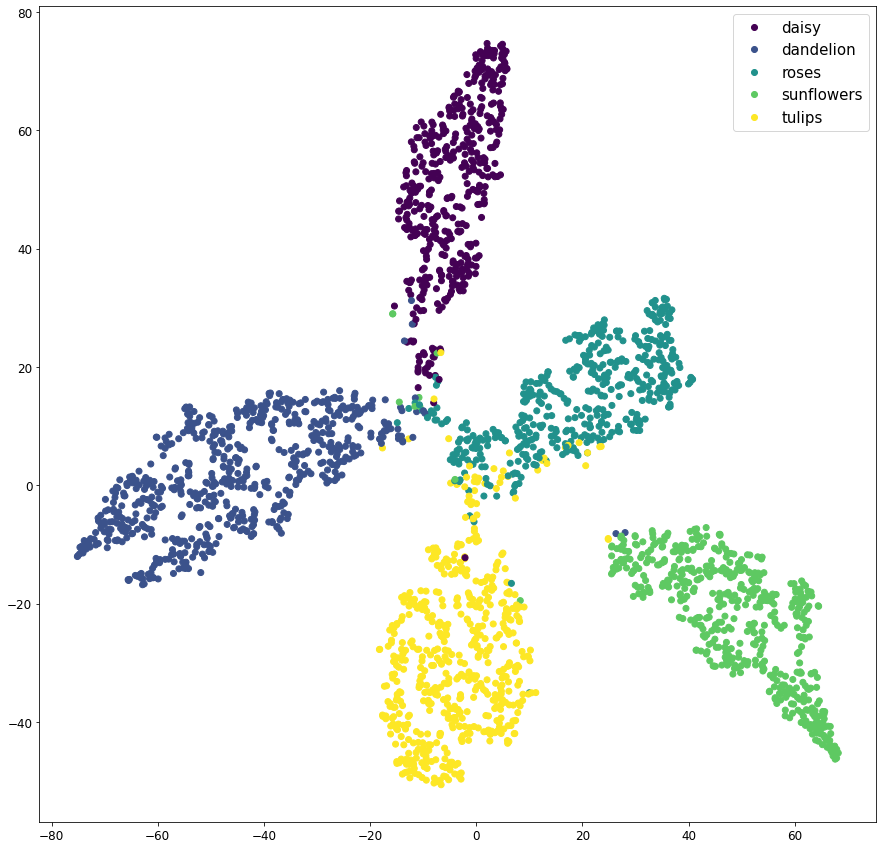

In [ ]:
# T-SNE

outputs, labels = get_representations(model, train_iterator, device = device)
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, classes, method = 't-sne')

Para concluir (simplemente como dato añadido), vamos a representar algunas de las imágenes de salida de los filtros de la primera capa convolucional de la red. Como era de esperar, sus activaciones son bastante genéricas (bordes, contornos, backgrounds, colores, etc...), así que podemos considerarlo como una indicación más de que el modelo ha entrenado sin problema.



---



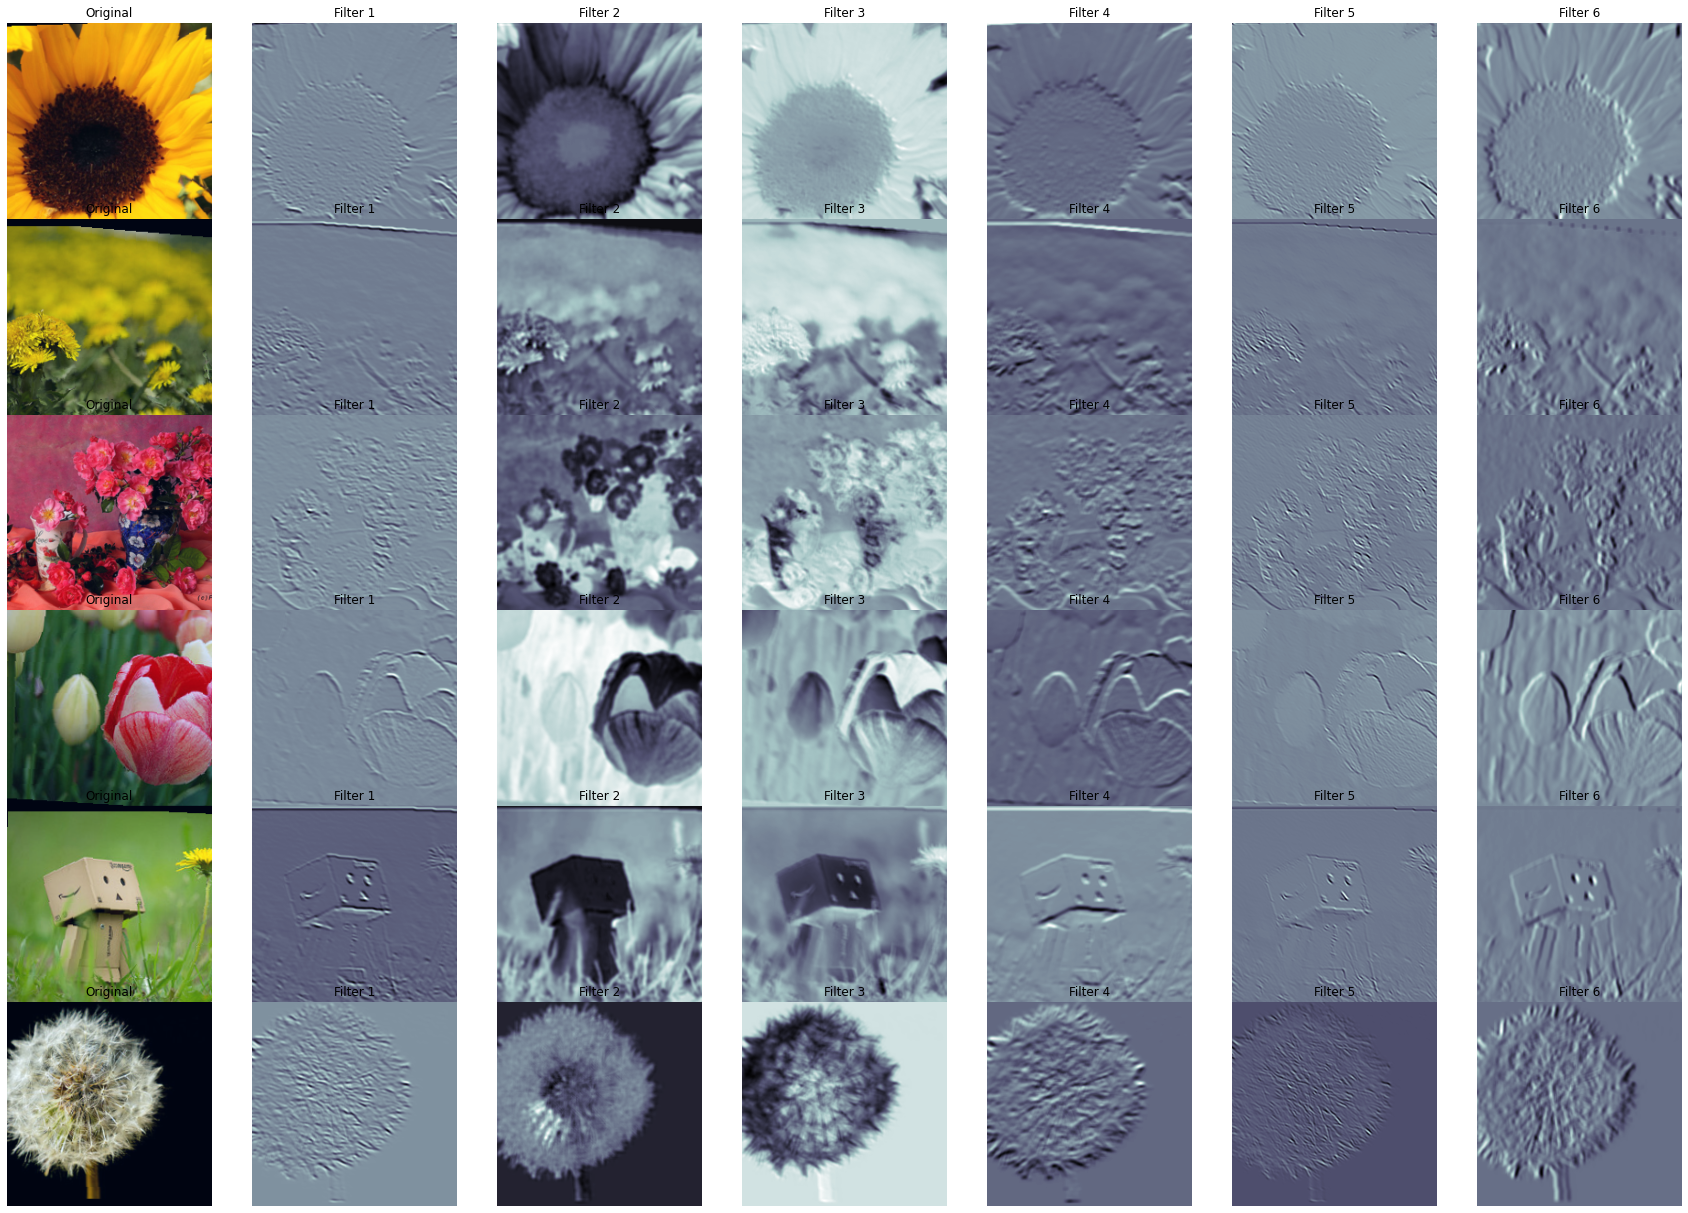

In [ ]:
# FILTER INTERPRETABILITY

images = [image for image, label in [train_data[i] for i in range(6)]]
filters = model.conv1.weight.data
plot_filtered_images(images, filters, 6)